In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer




from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report,precision_score, recall_score,roc_curve, roc_auc_score, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder,StandardScaler, MinMaxScaler,LabelBinarizer

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization,Flatten, Embedding, LSTM, GRU
from tensorflow.keras.utils import to_categorical

tfidf = TfidfVectorizer(stop_words=set(stopwords.words('english')),max_features=500)
sid = SentimentIntensityAnalyzer()
scaler = StandardScaler()
lb = LabelBinarizer()

In [113]:

def show_roc(y_val,y_pred):
    lb.fit(y_val)
    y_val1 = lb.transform(y_val)
    y_pred1 = lb.transform(y_pred)
    print(roc_auc_score(y_val1, y_pred1, average='weighted'))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_val1[:, i], y_pred1[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    lw=2
    for i in range(3):
        plt.plot(fpr[i], tpr[i], lw=lw,
                label='ROC curve of class Model (area = {1:0.2f})'
                ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic of current Model')
    plt.legend(loc="lower right")
    plt.show()

In [114]:
train_df = pd.read_csv("..\Datasets\Ecommerce\\train_data.csv")
test_df = pd.read_csv("..\Datasets\Ecommerce\\test_data.csv")
test_val_df = pd.read_csv("..\Datasets\Ecommerce\\test_data_hidden.csv")
train_df.shape,test_df.shape

((4000, 8), (1000, 7))

In [115]:
train_df.duplicated().sum(), test_df.duplicated().sum(), test_val_df.duplicated().sum()

(58, 3, 3)

In [116]:
train_df.describe()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
count,4000,4000,4000,4000,4000,4000,3990,4000
unique,23,1,23,4,638,3598,2606,3
top,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,I bought this kindle for my 11yr old granddaug...,Great tablet,Positive
freq,676,4000,628,2600,99,4,100,3749


In [117]:
train_df.dtypes

name                 object
brand                object
categories           object
primaryCategories    object
reviews.date         object
reviews.text         object
reviews.title        object
sentiment            object
dtype: object

In [118]:
test_df.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",Amazon,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,Amazon kindle fire has a lot of free app and c...,very handy device
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,The Echo Show is a great addition to the Amazo...,Another winner from Amazon
2,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-02T00:00:00.000Z,Great value from Best Buy. Bought at Christmas...,simple to use and reliable so far
3,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-03-25T00:00:00.000Z,"I use mine for email, Facebook ,games and to g...",Love it!!!
4,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-11-15T00:00:00.000Z,This is a fantastic item & the person I bought...,Fantastic!


In [119]:
test_df.describe()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title
count,1000,1000,1000,1000,1000,1000,997
unique,23,1,23,4,366,979,796
top,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,purchased for my grandson. He loves it. When s...,Great tablet
freq,169,1000,169,676,26,2,22


In [120]:
test_val_df.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",Amazon,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,Amazon kindle fire has a lot of free app and c...,very handy device,Positive
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,The Echo Show is a great addition to the Amazo...,Another winner from Amazon,Positive
2,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-02T00:00:00.000Z,Great value from Best Buy. Bought at Christmas...,simple to use and reliable so far,Positive
3,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-03-25T00:00:00.000Z,"I use mine for email, Facebook ,games and to g...",Love it!!!,Positive
4,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-11-15T00:00:00.000Z,This is a fantastic item & the person I bought...,Fantastic!,Positive


In [121]:
test_val_df.describe()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
count,1000,1000,1000,1000,1000,1000,997,1000
unique,23,1,23,4,366,979,796,3
top,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,purchased for my grandson. He loves it. When s...,Great tablet,Positive
freq,169,1000,169,676,26,2,22,937


In [122]:
train_df.isnull().sum()

name                  0
brand                 0
categories            0
primaryCategories     0
reviews.date          0
reviews.text          0
reviews.title        10
sentiment             0
dtype: int64

In [123]:
test_df.isnull().sum()

name                 0
brand                0
categories           0
primaryCategories    0
reviews.date         0
reviews.text         0
reviews.title        3
dtype: int64

In [124]:
train_df["sentiment"].value_counts()

Positive    3749
Neutral      158
Negative      93
Name: sentiment, dtype: int64

In [125]:
Positive_Review_Text = ""
for review in  train_df[train_df["sentiment"]=="Positive"]["reviews.text"]:
  Positive_Review_Text += " " +review.lower()

Negative_Review_Text = ""
for review in  train_df[train_df["sentiment"]=="Negative"]["reviews.text"]:
  Negative_Review_Text += " " +review.lower()

Neutral_Review_Text = ""
for review in  train_df[train_df["sentiment"]=="Neutral"]["reviews.text"]:
  Neutral_Review_Text += " " +review.lower()


In [126]:
class WordCloudGeneration:
    def preprocessing(self, data):
        data = data.split(".")
        # convert all words to lowercase
        data = [item.lower() for item in data]
        # load the stop_words of english
        stop_words = set(stopwords.words('english'))
        # concatenate all the data with spaces.
        paragraph = ' '.join(data)
        # tokenize the paragraph using the inbuilt tokenizer
        word_tokens = word_tokenize(paragraph) 
        # filter words present in stopwords list 
        preprocessed_data = ' '.join([word for word in word_tokens if not word in stop_words])
        return preprocessed_data

    def create_word_cloud(self, final_data,title=""):
        final_data=self.preprocessing(final_data)

        wordcloud = WordCloud(width=1600, height=800, max_font_size=200, background_color="white").generate(final_data)
        plt.figure(figsize=(12,10))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.title(title,fontsize=40)
        plt.show()

        
wordcloud_generator = WordCloudGeneration()

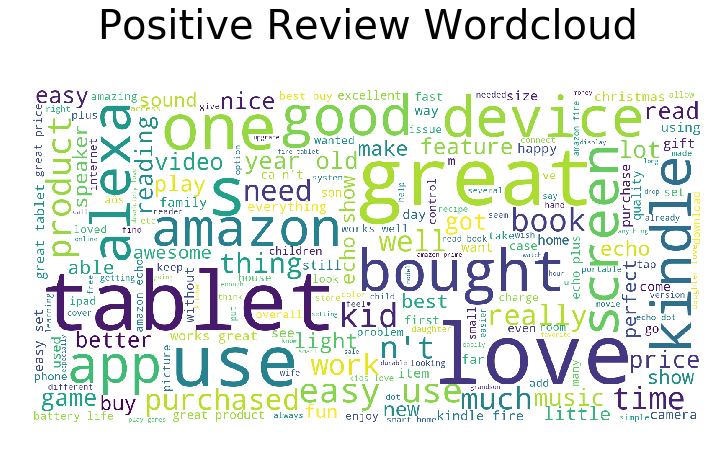

In [127]:

wordcloud_generator.create_word_cloud(Positive_Review_Text,"Positive Review Wordcloud\n")

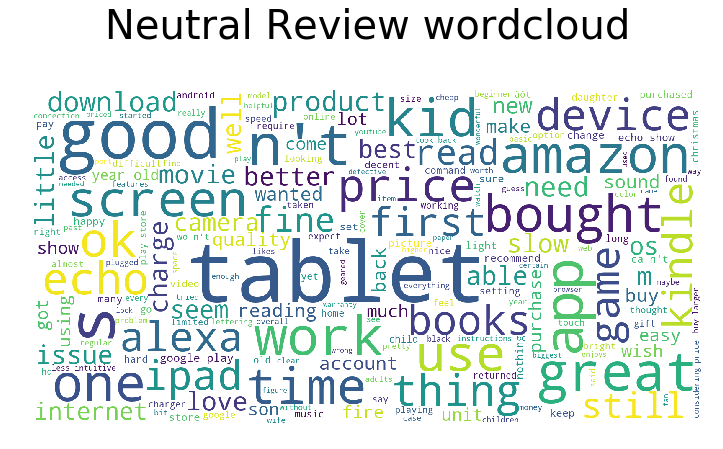

In [128]:
wordcloud_generator.create_word_cloud(Neutral_Review_Text,"Neutral Review wordcloud\n")

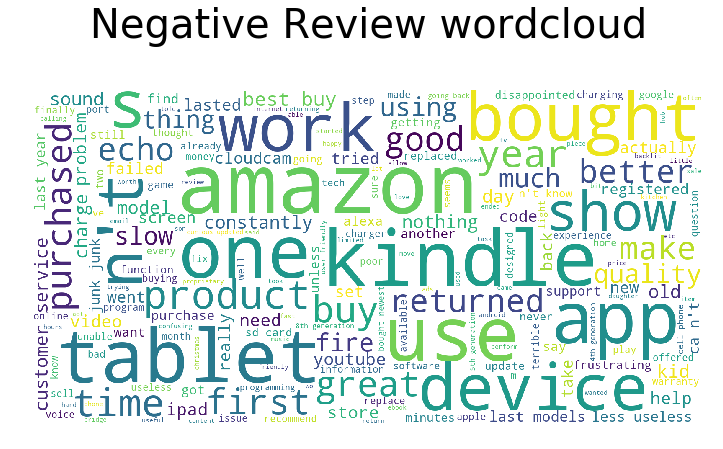

In [129]:
wordcloud_generator.create_word_cloud(Negative_Review_Text,"Negative Review wordcloud\n")

# Observations 

Duplicates found in all datasets


Only one brand. - brand column can be dropped:

name, categories, primaryCategories, and sentiment are categorical:
**LabelEncoder**

reviews.date to be converted to DateTime (Drop or not?):

reviews.text and reviews.title are text:
**TFIDF**
**Sentiment Analysis**

null values in reviews.title:


class imbalance issue:
**undersampling**
**oversampling**
**class weights**



# Tasks based on observations

Remove Duplicates

In [130]:
train_df=train_df[train_df.duplicated()==False]
test_df=test_df[test_df.duplicated()==False]
test_val_df=test_val_df[test_val_df.duplicated()==False]

train_df.reset_index(inplace=True)
test_val_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)

fill null values

In [131]:
train_df['reviews.title'].fillna(value='',inplace=True)
test_val_df['reviews.title'].fillna(value=' ',inplace=True)
test_df['reviews.title'].fillna(value=' ',inplace=True)

Drop Brand Category

In [132]:
train_df.drop("brand",inplace=True,axis=1)
test_df.drop("brand",inplace=True,axis=1)
test_val_df.drop("brand",inplace=True,axis=1)

Encode categories

In [133]:
def to_labels(series):
  le=LabelEncoder()
  return le.fit_transform(series)

categories = ["name","categories","primaryCategories","sentiment"]

for cat in categories:
  train_df[cat]=to_labels(train_df[cat])
  test_val_df[cat]=to_labels(test_val_df[cat])
  if not cat=="sentiment":
    test_df[cat]=to_labels(test_df[cat])


train_df.shape,test_df.shape,test_val_df.shape

((3942, 8), (997, 7), (997, 8))

Vectorize text with Tfidf

In [134]:

lemmatizer = WordNetLemmatizer()
def get_tfidf(series):
    print("Calclating tfidf")

    new_series=[]
    for review in series:
        toks = word_tokenize(review)
        toks_sans_stopwords = [word for word in toks if not word in set(stopwords.words('english'))]
        review_lemma = lemmatizer.lemmatize(" ".join(toks_sans_stopwords))
        new_series.append(review_lemma)
    result=pd.DataFrame(tfidf.fit_transform(new_series).toarray())
    print("calculation complete")
    return result

In [135]:
def get_sentiment_scores(df):
    print("Calclating Polarity Scores - Reviews.text")
    df["reviews.text_scores"] = np.array(df["reviews.text"].map(lambda x: sid.polarity_scores(x)))
    print("Calclating Polarity Scores - Reviews.titl")
    df["reviews.title_scores"] = np.array(df["reviews.title"].map(lambda x: sid.polarity_scores(x)))
    neg=[]
    neu=[]
    pos=[]
    for scores in df["reviews.text_scores"]:
        neg.append(scores["neg"])
        neu.append(scores["neu"])
        pos.append(scores["pos"])
    df["reviews_text_neg"] = np.array(neg)
    df["reviews_text_neu"] = np.array(neu)
    df["reviews_text_pos"] = np.array(pos)
    df.drop(["reviews.text_scores","reviews.title_scores"],axis=1,inplace=True)
    
    print("Calclating Polarity Scores - Complete")



In [136]:
get_sentiment_scores(train_df)
get_sentiment_scores(test_df)
get_sentiment_scores(test_val_df)

train_df=pd.concat((train_df,get_tfidf(train_df["reviews.text"])),axis=1).drop("reviews.text",axis=1)
test_df=pd.concat((test_df,get_tfidf(test_df["reviews.text"])),axis=1).drop("reviews.text",axis=1)
test_val_df=pd.concat((test_val_df,get_tfidf(test_val_df["reviews.text"])),axis=1).drop("reviews.text",axis=1)

train_df=pd.concat((train_df,get_tfidf(train_df["reviews.title"])),axis=1).drop("reviews.title",axis=1)
test_df=pd.concat((test_df,get_tfidf(test_df["reviews.title"])),axis=1).drop("reviews.title",axis=1)
test_val_df=pd.concat((test_val_df,get_tfidf(test_val_df["reviews.title"])),axis=1).drop("reviews.title",axis=1)

train_df.shape,test_df.shape,test_val_df.shape

Calclating Polarity Scores - Reviews.text
Calclating Polarity Scores - Reviews.titl
Calclating Polarity Scores - Complete
Calclating Polarity Scores - Reviews.text
Calclating Polarity Scores - Reviews.titl
Calclating Polarity Scores - Complete
Calclating Polarity Scores - Reviews.text
Calclating Polarity Scores - Reviews.titl
Calclating Polarity Scores - Complete
Calclating tfidf
calculation complete
Calclating tfidf
calculation complete
Calclating tfidf
calculation complete
Calclating tfidf
calculation complete
Calclating tfidf
calculation complete
Calclating tfidf
calculation complete


((3942, 1009), (997, 1008), (997, 1009))

In [137]:

train_df['reviews.date'] = train_df['reviews.date'].str.split('T').str[0]
test_val_df['reviews.date'] = test_val_df['reviews.date'].str.split('T').str[0]
test_df['reviews.date'] = test_df['reviews.date'].str.split('T').str[0]

train_df['reviews_day'] = pd.to_datetime(train_df['reviews.date'], format='%Y-%m-%d').dt.day
train_df['reviews_month'] = pd.to_datetime(train_df['reviews.date'], format='%Y-%m-%d').dt.month
train_df['reviews_year'] = pd.to_datetime(train_df['reviews.date'], format='%Y-%m-%d').dt.year

test_val_df['reviews_day'] = pd.to_datetime(test_val_df['reviews.date'], format='%Y-%m-%d').dt.day
test_val_df['reviews_month'] = pd.to_datetime(test_val_df['reviews.date'], format='%Y-%m-%d').dt.month
test_val_df['reviews_year'] = pd.to_datetime(test_val_df['reviews.date'], format='%Y-%m-%d').dt.year

test_df['reviews_day'] = pd.to_datetime(test_df['reviews.date'], format='%Y-%m-%d').dt.day
test_df['reviews_month'] = pd.to_datetime(test_df['reviews.date'], format='%Y-%m-%d').dt.month
test_df['reviews_year'] = pd.to_datetime(test_df['reviews.date'], format='%Y-%m-%d').dt.year


In [138]:

X_train = np.array(train_df.drop(["sentiment","reviews.date","index"],axis=1))


y_train = np.array(train_df["sentiment"])
y_test = np.array(test_val_df["sentiment"])

X_test = np.array(test_val_df.drop(["reviews.date","sentiment","index"],axis=1))
print(X_test.shape,y_test.shape,X_train.shape,y_train.shape)

(997, 1009) (997,) (3942, 1009) (3942,)


In [139]:
test_val_df.drop(["reviews.date","index"],axis=1, inplace=True)

# Multinomial Naive Bayes Classification

In [140]:
model = MultinomialNB()

In [141]:
model.fit(X_train,y_train)

MultinomialNB()

In [142]:
def show_metrics(true_vals,pred_vals):
    print(f"Balanced Accuracy Score:{metrics.balanced_accuracy_score(true_vals,preds)}\n")
    print(pd.DataFrame(confusion_matrix(true_vals,pred_vals),columns=["negative","neutral","positive"],index=["negative","neutral","positive"]))
    print("\n")
    print(classification_report(true_vals,pred_vals))
    show_roc(true_vals,pred_vals)

In [143]:
preds=model.predict(X_test)
print(metrics.balanced_accuracy_score(y_test,preds))

0.32548179871520344


Balanced Accuracy Score:0.32548179871520344

          negative  neutral  positive
negative         0        0        24
neutral          0        0        39
positive         0       22       912


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.00      0.00      0.00        39
           2       0.94      0.98      0.96       934

    accuracy                           0.91       997
   macro avg       0.31      0.33      0.32       997
weighted avg       0.88      0.91      0.90       997

0.48851774530271397


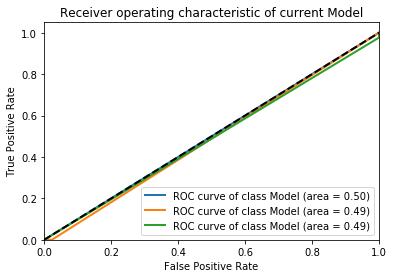

In [144]:
show_metrics(y_test,preds)

# Dealing with class Imbalance

In [145]:
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier 
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier

In [146]:
oversample=RandomOverSampler(sampling_strategy="not majority")
undersample=RandomUnderSampler(sampling_strategy="not minority")

# oversample LR

In [147]:
import sklearn.metrics as metrics
dir(metrics)

['ConfusionMatrixDisplay',
 'DetCurveDisplay',
 'DistanceMetric',
 'PrecisionRecallDisplay',
 'RocCurveDisplay',
 'SCORERS',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_base',
 '_classification',
 '_dist_metrics',
 '_pairwise_fast',
 '_plot',
 '_ranking',
 '_regression',
 '_scorer',
 'accuracy_score',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'auc',
 'average_precision_score',
 'balanced_accuracy_score',
 'brier_score_loss',
 'calinski_harabasz_score',
 'check_scoring',
 'classification_report',
 'cluster',
 'cohen_kappa_score',
 'completeness_score',
 'confusion_matrix',
 'consensus_score',
 'coverage_error',
 'd2_tweedie_score',
 'davies_bouldin_score',
 'dcg_score',
 'det_curve',
 'euclidean_distances',
 'explained_variance_score',
 'f1_score',
 'fbeta_score',
 'fowlkes_mallows_score',
 'get_scorer',
 'hamming_loss',
 'hinge_loss',
 'homogeneity_completeness_v_measure',
 '

[Voting] ..................... (1 of 3) Processing FRST, total=   0.2s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   18.5s finished


[Voting] ....................... (2 of 3) Processing LR, total=  18.6s
[23:41:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Voting] ...................... (3 of 3) Processing xgb, total=  10.5s
Balanced Accuracy Score:0.5054288145829902

          negative  neutral  positive
negative        19        4         1
neutral         20        4        15
positive       223      130       581


              precision    recall  f1-score   support

           0       0.07      0.79      0.13        24
           1       0.03      0.10      0.05        39
           2       0.97      0.62      0.76       934

    accuracy                           0.61       997
   macro avg       0.36      0.51      0.31       997
weighted avg       0.91      0.61      0.72       997

0.6782069721496886


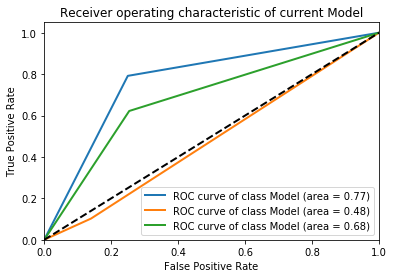

In [148]:
steps = [('u', undersample),
         ('model', VotingClassifier([
             ("FRST",RandomForestClassifier(class_weight='balanced')),
             ("LR",LogisticRegression(C=30, class_weight='balanced', solver='sag', 
                         multi_class='multinomial', random_state=40, 
                         verbose=1, max_iter=1000, n_jobs=4)),
                         ("xgb", XGBClassifier(n_estimators=1000,max_depth=6))
             ],verbose=True))]

pipeline = Pipeline(steps=steps)

pipeline.fit(X_train,y_train)

preds = pipeline.predict(X_test)

show_metrics(y_test,preds)

In [149]:
models=[
        LogisticRegression(class_weight='balanced'),
        # SVC(class_weight='balanced'),
        DecisionTreeClassifier(class_weight='balanced'),
        RandomForestClassifier(class_weight='balanced'),
        # MultinomialNB(),
        XGBClassifier(n_estimators=1000,max_depth=6)
        ]


LogisticRegression(class_weight='balanced')  -- control 
 ************************************************** 

Balanced Accuracy Score:0.43548106663738356

          negative  neutral  positive
negative        14        5         5
neutral         13       12        14
positive       257      289       388


              precision    recall  f1-score   support

           0       0.05      0.58      0.09        24
           1       0.04      0.31      0.07        39
           2       0.95      0.42      0.58       934

    accuracy                           0.42       997
   macro avg       0.35      0.44      0.25       997
weighted avg       0.90      0.42      0.55       997

0.5570155268567728


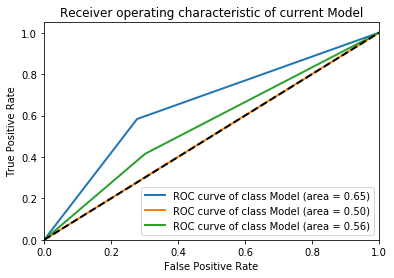

DecisionTreeClassifier(class_weight='balanced')  -- control 
 ************************************************** 

Balanced Accuracy Score:0.44256163180146046

          negative  neutral  positive
negative         7        4        13
neutral          6        7        26
positive        74       60       800


              precision    recall  f1-score   support

           0       0.08      0.29      0.13        24
           1       0.10      0.18      0.13        39
           2       0.95      0.86      0.90       934

    accuracy                           0.82       997
   macro avg       0.38      0.44      0.39       997
weighted avg       0.90      0.82      0.85       997

0.6159632985529263


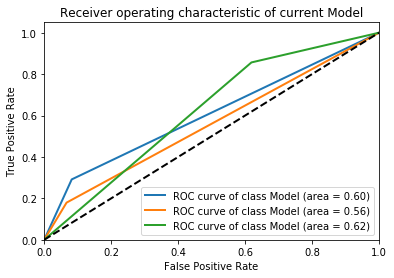

RandomForestClassifier(class_weight='balanced')  -- control 
 ************************************************** 

Balanced Accuracy Score:0.34722222222222227

          negative  neutral  positive
negative         1        0        23
neutral          0        0        39
positive         0        0       934


              precision    recall  f1-score   support

           0       1.00      0.04      0.08        24
           1       0.00      0.00      0.00        39
           2       0.94      1.00      0.97       934

    accuracy                           0.94       997
   macro avg       0.65      0.35      0.35       997
weighted avg       0.90      0.94      0.91       997

0.5079365079365079


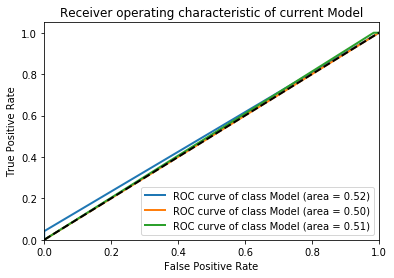

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=6,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)  -- control 
 ************************************************** 

[23:41:34] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavi

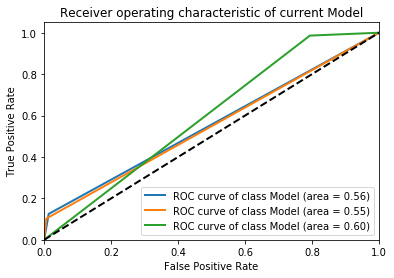

In [150]:
for model in models:
    print(model," -- control","\n","*"*50,"\n")

    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    show_metrics(y_test,preds)

LogisticRegression(class_weight='balanced')  -- oversampled 
 ************************************************** 

Balanced Accuracy Score:0.4540758432621388

          negative  neutral  positive
negative        14        6         4
neutral         14       10        15
positive       228      218       488


              precision    recall  f1-score   support

           0       0.05      0.58      0.10        24
           1       0.04      0.26      0.07        39
           2       0.96      0.52      0.68       934

    accuracy                           0.51       997
   macro avg       0.35      0.45      0.28       997
weighted avg       0.90      0.51      0.64       997

0.6079384628294978


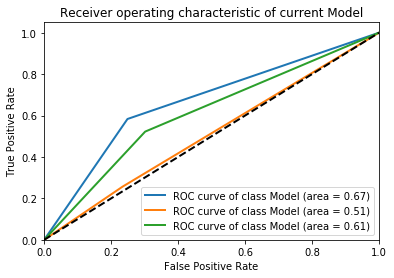

DecisionTreeClassifier(class_weight='balanced')  -- oversampled 
 ************************************************** 

Balanced Accuracy Score:0.4457621845202145

          negative  neutral  positive
negative         8        4        12
neutral          7        6        26
positive        58       82       794


              precision    recall  f1-score   support

           0       0.11      0.33      0.16        24
           1       0.07      0.15      0.09        39
           2       0.95      0.85      0.90       934

    accuracy                           0.81       997
   macro avg       0.38      0.45      0.39       997
weighted avg       0.90      0.81      0.85       997

0.6201256710110589


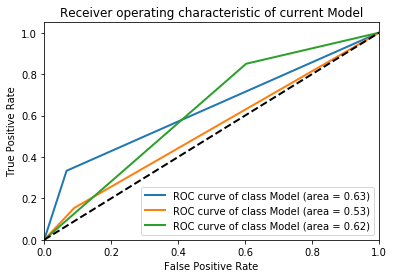

RandomForestClassifier(class_weight='balanced')  -- oversampled 
 ************************************************** 

Balanced Accuracy Score:0.35896978348798475

          negative  neutral  positive
negative         2        0        22
neutral          0        0        39
positive         6        0       928


              precision    recall  f1-score   support

           0       0.25      0.08      0.12        24
           1       0.00      0.00      0.00        39
           2       0.94      0.99      0.97       934

    accuracy                           0.93       997
   macro avg       0.40      0.36      0.36       997
weighted avg       0.89      0.93      0.91       997

0.5127897681854516


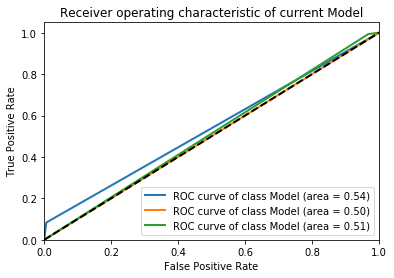

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)  -- oversampled 
 ************************************************** 

[23:43:38] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old be

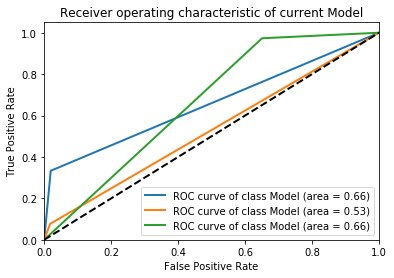

In [151]:
for model in models:
    print(model," -- oversampled","\n","*"*50,"\n")
    steps = [("o",oversample),('model', model)]
    pipeline = Pipeline(steps=steps)
    pipeline.fit(X_train,y_train)
    preds = pipeline.predict(X_test)
    show_metrics(y_test,preds)

LogisticRegression(class_weight='balanced')  -- undersampled 
 ************************************************** 

Balanced Accuracy Score:0.47538617104998265

          negative  neutral  positive
negative        15        5         4
neutral         15       14        10
positive       335      186       413


              precision    recall  f1-score   support

           0       0.04      0.62      0.08        24
           1       0.07      0.36      0.11        39
           2       0.97      0.44      0.61       934

    accuracy                           0.44       997
   macro avg       0.36      0.48      0.27       997
weighted avg       0.91      0.44      0.57       997

0.6093459261818103


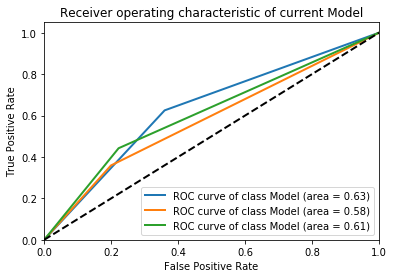

DecisionTreeClassifier(class_weight='balanced')  -- undersampled 
 ************************************************** 

Balanced Accuracy Score:0.5239412324530097

          negative  neutral  positive
negative        15        6         3
neutral         11       13        15
positive       148      213       573


              precision    recall  f1-score   support

           0       0.09      0.62      0.15        24
           1       0.06      0.33      0.10        39
           2       0.97      0.61      0.75       934

    accuracy                           0.60       997
   macro avg       0.37      0.52      0.33       997
weighted avg       0.91      0.60      0.71       997

0.6611361671176034


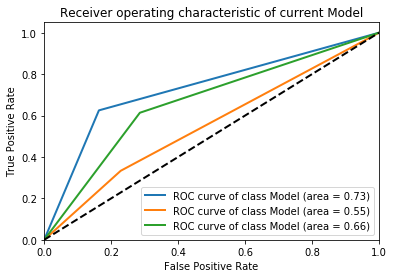

RandomForestClassifier(class_weight='balanced')  -- undersampled 
 ************************************************** 

Balanced Accuracy Score:0.5128777064001904

          negative  neutral  positive
negative        15        7         2
neutral         15       13        11
positive       117      275       542


              precision    recall  f1-score   support

           0       0.10      0.62      0.18        24
           1       0.04      0.33      0.08        39
           2       0.98      0.58      0.73       934

    accuracy                           0.57       997
   macro avg       0.37      0.51      0.33       997
weighted avg       0.92      0.57      0.69       997

0.6818123193064994


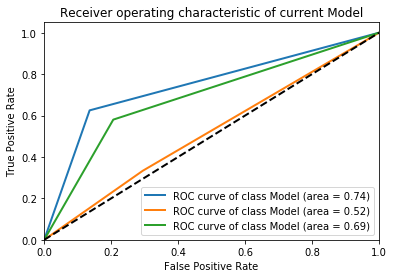

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)  -- undersampled 
 ************************************************** 

[23:48:18] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old b

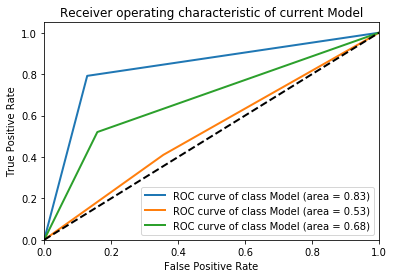

In [152]:
for model in models:
    print(model," -- undersampled","\n","*"*50,"\n")
    steps = [("o",undersample),('model', model)]
    pipeline = Pipeline(steps=steps)
    pipeline.fit(X_train,y_train)
    preds = pipeline.predict(X_test)
    show_metrics(y_test,preds)

LogisticRegression(class_weight='balanced')  -- over/under 
 ************************************************** 

Balanced Accuracy Score:0.4344424312304398

          negative  neutral  positive
negative        16        3         5
neutral         16        7        16
positive       293      214       427


              precision    recall  f1-score   support

           0       0.05      0.67      0.09        24
           1       0.03      0.18      0.05        39
           2       0.95      0.46      0.62       934

    accuracy                           0.45       997
   macro avg       0.34      0.43      0.25       997
weighted avg       0.90      0.45      0.58       997

0.5612892924550905


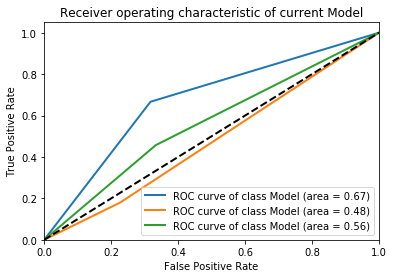

DecisionTreeClassifier(class_weight='balanced')  -- over/under 
 ************************************************** 

Balanced Accuracy Score:0.5173525320741595

          negative  neutral  positive
negative        11        4         9
neutral          7        9        23
positive        74       54       806


              precision    recall  f1-score   support

           0       0.12      0.46      0.19        24
           1       0.13      0.23      0.17        39
           2       0.96      0.86      0.91       934

    accuracy                           0.83       997
   macro avg       0.41      0.52      0.42       997
weighted avg       0.91      0.83      0.86       997

0.6741365035022384


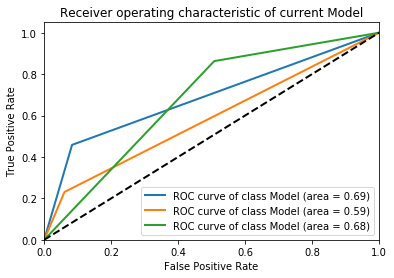

RandomForestClassifier(class_weight='balanced')  -- over/under 
 ************************************************** 

Balanced Accuracy Score:0.38817511301451346

          negative  neutral  positive
negative         4        0        20
neutral          0        0        39
positive         2        0       932


              precision    recall  f1-score   support

           0       0.67      0.17      0.27        24
           1       0.00      0.00      0.00        39
           2       0.94      1.00      0.97       934

    accuracy                           0.94       997
   macro avg       0.54      0.39      0.41       997
weighted avg       0.90      0.94      0.91       997

0.5307182825168436


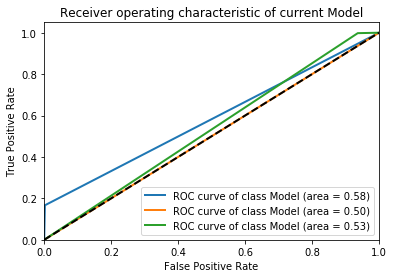

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)  -- over/under 
 ************************************************** 

[23:48:42] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old beh

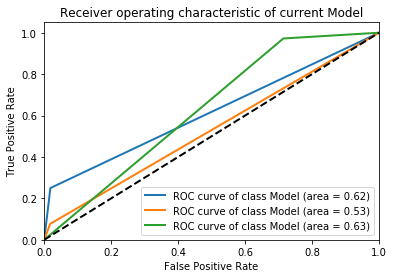

In [153]:
for model in models:
    print(model," -- over/under","\n","*"*50,"\n")
    steps = [("o",oversample),("u", undersample),('model', model)]
    pipeline = Pipeline(steps=steps)
    pipeline.fit(X_train,y_train)
    preds = pipeline.predict(X_test)
    show_metrics(y_test,preds)

[23:53:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Balanced Accuracy Score:0.5540868244294369

          negative  neutral  positive
negative        22        2         0
neutral         21       12         6
positive       192      333       409


              precision    recall  f1-score   support

           0       0.09      0.92      0.17        24
           1       0.03      0.31      0.06        39
           2       0.99      0.44      0.61       934

    accuracy                           0.44       997
   macro avg       0.37      0.55      0.28       997
weighted avg       0.93      0.44      0.57       997

0.6680822356728396


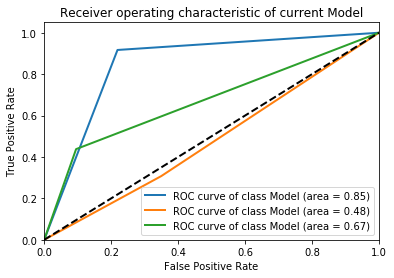

In [154]:
steps = [("o",undersample),('model', VotingClassifier([("XGB", XGBClassifier(n_estimators=1000,max_depth=6)),("FRST", RandomForestClassifier(class_weight="balanced"))]))]
pipeline = Pipeline(steps=steps)
pipeline.fit(X_train,y_train)
preds = pipeline.predict(X_test)
show_metrics(y_test,preds)

In [155]:
NN= Sequential()
NN.add(Flatten())
NN.add(Dense(128, activation="relu"))
NN.add(Dropout(.4))
NN.add(Dense(256,activation="relu"))
NN.add(Dropout(.4))
NN.add(Dense(512,activation="relu"))

NN.add(Dropout(.4))
NN.add(Dense(3,activation="softmax"))
NN.compile(optimizer="adam",loss="categorical_crossentropy")

In [156]:
X,y = oversample.fit_resample(X_train,y_train)
X,y = undersample.fit_resample(X_train,y_train)

NN.fit(X,y,epochs=100)

Epoch 1/100
270/270 [==============================] - 6s 24ms/sample - loss: 30.6858
Epoch 2/100
270/270 [==============================] - 0s 608us/sample - loss: 31.8663
Epoch 3/100
270/270 [==============================] - 0s 679us/sample - loss: 31.3620
Epoch 4/100
270/270 [==============================] - 0s 698us/sample - loss: 31.9146
Epoch 5/100
270/270 [==============================] - 0s 682us/sample - loss: 31.6865
Epoch 6/100
270/270 [==============================] - 0s 701us/sample - loss: 31.7975
Epoch 7/100
270/270 [==============================] - 0s 715us/sample - loss: 31.1323
Epoch 8/100
270/270 [==============================] - 0s 661us/sample - loss: 31.7719
Epoch 9/100
270/270 [==============================] - 0s 756us/sample - loss: 31.7059
Epoch 10/100
270/270 [==============================] - 0s 680us/sample - loss: 31.9962
Epoch 11/100
270/270 [==============================] - 0s 695us/sample - loss: 32.1580
Epoch 12/100
270/270 [====================

In [157]:
preds_array = NN.predict(X_test)
pred_list = []
for i,pred in enumerate(preds_array):
    pred_list.append(pred.argmax())

Balanced Accuracy Score:0.5540868244294369

          negative  neutral  positive
negative         0       24         0
neutral          0       39         0
positive         0      934         0


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.04      1.00      0.08        39
           2       0.00      0.00      0.00       934

    accuracy                           0.04       997
   macro avg       0.01      0.33      0.03       997
weighted avg       0.00      0.04      0.00       997

0.5


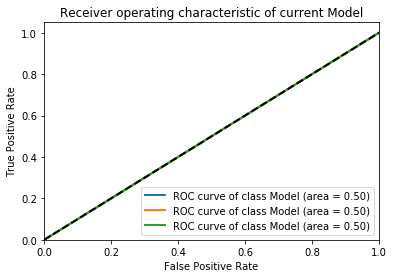

In [158]:
show_metrics(y_test,pred_list)

In [159]:
X_train.shape,y_train.shape

((3942, 1009), (3942,))

In [162]:
print(tf.__version__)

1.13.1


In [176]:
from sklearn.preprocessing import label_binarize
X,y = oversample.fit_resample(X_train,y_train)


y_train2 = label_binarize(y, classes=[0, 1, 2])
epochs = 5
emb_dim = 128
batch_size = 256
model = Sequential()
model.add(Embedding(X.shape[0], emb_dim, input_length=X.shape[1]))
#model.add(SpatialDropout1D(0.7))
model.add(GRU(64, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.FalseNegatives()])
model.fit(X, y_train2, epochs=epochs, batch_size=batch_size,workers=6)
preds = model.predict(X_test, batch_size=100)
preds = np.argmax(preds, axis=1)
show_metrics(y_test, preds)

Epoch 1/5
 1024/11082 [=>............................] - ETA: 8:53 - loss: 1.0982 - false_negatives_2: 1024.0000

KeyboardInterrupt: 

In [167]:
auc

<function sklearn.metrics._ranking.auc(x, y)>